In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import requests 
url="https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
res=requests.get(url)
words=(res.text).splitlines()
print(len(words),max(len(w) for w in words),min(len(w) for w in words))

32033 15 2


In [3]:
chars =sorted(list(set((''.join(words))))) #get unique characters 
stoi={s:i+1 for i, s in enumerate(chars)}  # map char to int
stoi["."]=0 
itos={i:s for s,i in stoi.items()}         # map int to char

In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [114]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C =  torch.randn((27, 10),  generator=g)*0.1
W1 = torch.randn((30, 200), generator=g)*0.2
b1 = torch.randn(200,       generator=g)*0
W2 = torch.randn((200, 27), generator=g)*0.01
b2 = torch.randn(27,        generator=g)*0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

lri = []
lossi = []
stepi = []

In [122]:
nSamples=32
for i in range(1000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (nSamples,))
  
  # forward pass
  emb = C[Xtr[ix]]           #embed charchters in to vectors
  embcat=emb.view(-1, 30)    #convert 3*10 to nsamples*30
  hpreact=embcat @ W1 + b1
  hpreact=hpreact-hpreact.mean(dim=0, keepdim=True) #subtract the standard deviation
  hpreact=hpreact/hpreact.std(dim=0, keepdim=True)  #divide by the mean 
  h = torch.tanh(hpreact) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  for p in parameters:
    p.data += -0.1*p.grad

  # track stats
  
  stepi.append(i)
  lossi.append(loss.log10().item())
  if i%200==0:

    print(loss)
  


tensor(2.0124, grad_fn=<NllLossBackward0>)
tensor(2.0443, grad_fn=<NllLossBackward0>)
tensor(2.5687, grad_fn=<NllLossBackward0>)
tensor(2.2765, grad_fn=<NllLossBackward0>)
tensor(2.1486, grad_fn=<NllLossBackward0>)


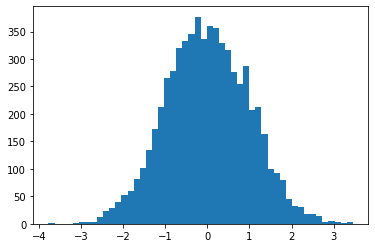

In [123]:
plt.hist(hpreact.view(-1).tolist(),50)
pass

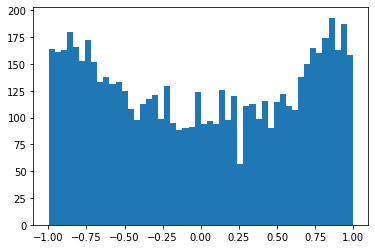

In [124]:
plt.hist(h.view(-1).tolist(),50)
pass

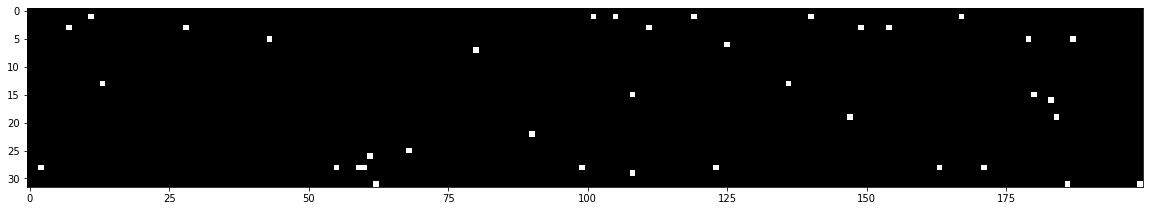

In [125]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap="gray",interpolation='nearest')

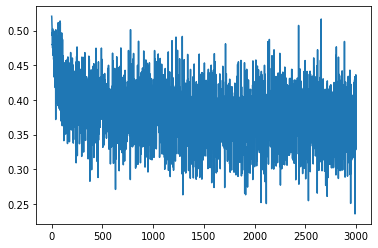

In [126]:
plt.plot(lossi)

In [103]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(f"train loss {loss}")
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(f"val loss {loss}")
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
print(f"test  loss {loss}")

train loss 2.6418099403381348
val loss 2.640054941177368
test  loss 2.6427321434020996


In [12]:
# Everything here is after 1000 steps

# Raw model
    # train loss 7.168619632720947
    # val loss 7.161382675170898
    # test  loss 7.177533149719238
# Weights with proper initialization
    # train loss 2.3786191940307617
    # val loss 2.373582363128662
    # test  loss 2.374671220779419

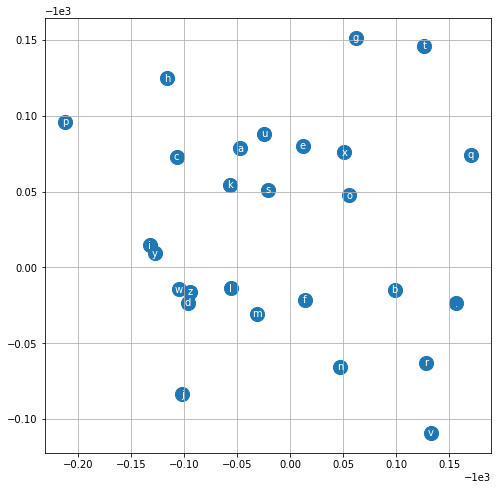

In [13]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [14]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

cbrpzhxqtbfhqvufkwmrpxgthtykhkcasskejrzhnbnfqpwsyhc.
vgqeiunrzmuqptcmziivduslhggphhbmgpoinfqsqjtzsrlixwawvvdbquwqjthogdjaryxixfkqeupiusdbwed.
ecxiatgtlffhysfkquhpqgmovdjhksyjrpmqqosozswjcojqmwycjsfrenqkpfsadluuo.
zoessrkoiazhrynhr.
opklhynrxyh.
xqioloqbprbvbbda.
ipyqmuitjpbvfpzpddgpycsislqwkkmcrkzauqnyjydpk.
kvweskauikzamdtefl.
ky.
qdyctoorowooktbykouokfbfcw.
zoipkzcs.
su.
eoaiunqqerosci.
ipjzyfbadyigluglcufwzyzdjokhnlhsjqsxmuadltjhvtoyaplwuw.
xisxwrdfv.
zphtzbiuzzsrvgpknbfyntiysfgdgkgmmj.
pugcrvdhpvdafpsdvkhzkxkimtvoscjupgawjmjqjwgvjflwkewtxjrclxdytpvhgqllyuil.
hiuc.
sfcmkjpmubjbiygh.
sqkaxzkkiihkncfslyfgevbayl.
